In [1]:
# Install the required libraries.
! pip install pafy youtube-dl moviepy
! pip install torch torchvision

  Using cached pafy-0.5.5-py2.py3-none-any.whl.metadata (10 kB)
  Using cached youtube_dl-2021.12.17-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached moviepy-1.0.3-py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached proglog-0.1.10-py3-none-any.whl.metadata (639 bytes)
  Using cached imageio_ffmpeg-0.4.9-py3-none-manylinux2010_x86_64.whl.metadata (1.7 kB)
Using cached pafy-0.5.5-py2.py3-none-any.whl (35 kB)
Using cached youtube_dl-2021.12.17-py2.py3-none-any.whl (1.9 MB)
Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
Using cached imageio_ffmpeg-0.4.9-py3-none-manylinux2010_x86_64.whl (26.9 MB)
Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [2]:
! pip install scikit-learn

1 .Import the Libraries

We will start by installing and importing the required libraries. -->

In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Set random seeds for reproducibility.
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
torch.manual_seed(seed_constant)
torch.cuda.manual_seed(seed_constant)

In [41]:
# from google.colab import drive
# drive.mount('/content/drive')

2. Visualize the Data.

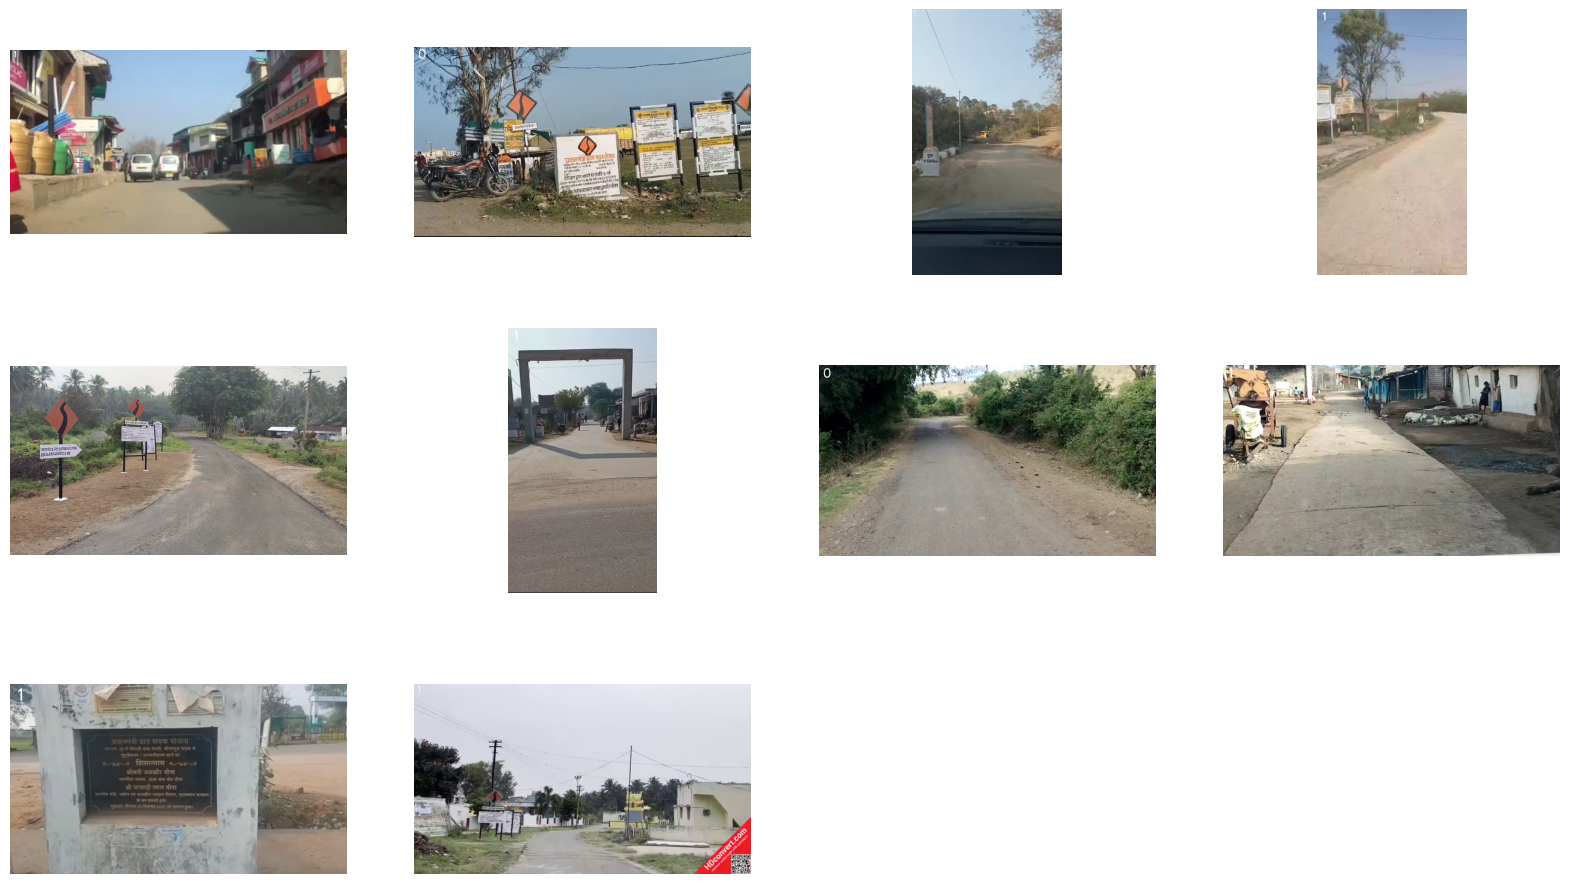

In [4]:
import os
import cv2
import json
import random
import matplotlib.pyplot as plt

# Define the function to convert time to frame index
def time_to_frame_index(time, fps):
    """Converts time in various formats to frame index."""
    try:
        # Split the time string into hours, minutes, and seconds
        if ':' in time:
            time_parts = time.split(':')
            if len(time_parts) == 3:
                hours, minutes, seconds = map(int, time_parts)
            else:
                minutes, seconds = map(int, time_parts)
                hours = 0
        else:
            # If ':' is not present, attempt to split by other delimiters
            for delimiter in [';', '.', ',']:
                if delimiter in time:
                    time_parts = time.split(delimiter)
                    if len(time_parts) == 3:
                        hours, minutes, seconds = map(int, time_parts)
                    else:
                        minutes, seconds = map(int, time_parts)
                        hours = 0
                    break
            else:
                # If no valid delimiter is found, assume the time format is 'SS' (seconds)
                hours, minutes, seconds = 0, 0, int(time)

        # Calculate the total seconds
        total_seconds = hours * 3600 + minutes * 60 + seconds

        # Calculate the frame index
        frame_index = int(total_seconds * fps)

        return frame_index
    except ValueError:
        print("Error: Invalid time format:", time)
        return 0  # Return 0 as a default value if time format is invalid


# Load annotations from the JSON file
with open('/home/shubhamp/Downloads/video_dataset/temporalDataset.json', 'r') as f:
    annotations = json.load(f)

# Path to your dataset directory
dataset_dir = '/home/shubhamp/Downloads/video_dataset/video_emarg'

# Create a dictionary to store annotations by video file name
video_annotations = {}

# Iterate over each item in the JSON list
for item in annotations:
    # Extract video path and segments
    video_path = item['path']
    segments = item['segments']

    # Extract video file name from the path
    video_file = os.path.basename(video_path)

    # Initialize a list to store frame indices and labels
    frame_annotations = []

    # Read video to get frame rate (fps)
    video_reader = cv2.VideoCapture(video_path)
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Iterate over each segment
    for segment in segments:
        # Convert start and end times to frame indices
        start_time = segment['start_time']
        end_time = segment['end_time']
        start_frame = time_to_frame_index(start_time, fps)
        end_frame = time_to_frame_index(end_time, fps)

        # Extract label
        label = segment['label']

        # Append frame index and label to the list
        for frame_index in range(start_frame, end_frame + 1):
            frame_annotations.append((frame_index, label))

    # Add video annotations to the dictionary
    video_annotations[video_file] = frame_annotations

# Select a random sample of 20 videos from your dataset
selected_videos = random.sample(list(video_annotations.keys()), 10)
# print("Total number of videos available:", len(video_annotations))
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize=(20, 20))

# Iterate through the selected videos
for i, video_file in enumerate(selected_videos, 1):
    # Read the video
    video_path = os.path.join(dataset_dir, video_file)
    video_reader = cv2.VideoCapture(video_path)

    # Read the first frame of the video
    _, frame = video_reader.read()

    # Convert the frame from BGR to RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get the corresponding annotation for the video
    annotation = video_annotations.get(video_file, [])

    # Select a random frame index with its annotation
    if annotation:
        frame_index, label = random.choice(annotation)
    else:
        frame_index = 0
        label = "No annotation"

    # Write the label on the video frame
    cv2.putText(rgb_frame, str(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    plt.subplot(5, 4, i)
    plt.imshow(rgb_frame)
    plt.axis('off')

    # Release the VideoCapture object
    video_reader.release()

plt.show()


3. Preprocess the Dataset

In [5]:
import os
import cv2
import torch
import torchvision.transforms as transforms

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing your custom dataset.
DATASET_DIR = "/home/shubhamp/Downloads/video_dataset/video_emarg"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["0", "1"]

# Resize and normalize frames for ResNet152
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet152 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Modify preprocess_video function to apply the transform
def preprocess_video(video_path):
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    while True:
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame)
        frames.append(frame)
    video_reader.release()
    frames = frames[:SEQUENCE_LENGTH] + [torch.zeros_like(frames[0])] * (SEQUENCE_LENGTH - len(frames))
    video_tensor = torch.stack(frames)
    return video_tensor


# # Example usage:
# video_path = os.path.join(DATASET_DIR, "example_video.mp4")
# video_tensor = preprocess_video(video_path)
# print("Processed video tensor shape:", video_tensor.shape)


4. Create a Function to Extract, Resize & Normalize Frames

In [6]:
import torch
import torchvision.transforms as transforms

# Resize and normalize frames for ResNet152
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet152 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def frames_extraction(video_path):
    """
    This function extracts frames from a video, resizes them, and normalizes them.

    Args:
        video_path: The path of the video file.

    Returns:
        video_tensor: A tensor containing the resized and normalized frames of the video.
    """
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    video_reader.release()

    # Transform all frames together
    frames = [transform(frame) for frame in frames]

    # Pad or truncate frames to ensure SEQUENCE_LENGTH
    frames = frames[:SEQUENCE_LENGTH] + [torch.zeros_like(frames[0])] * (SEQUENCE_LENGTH - len(frames))
    video_tensor = torch.stack(frames)

    # Add batch dimension to the tensor
    video_tensor = video_tensor.unsqueeze(0)

    return video_tensor



5. Label tagging to each frame from annotation.json file.

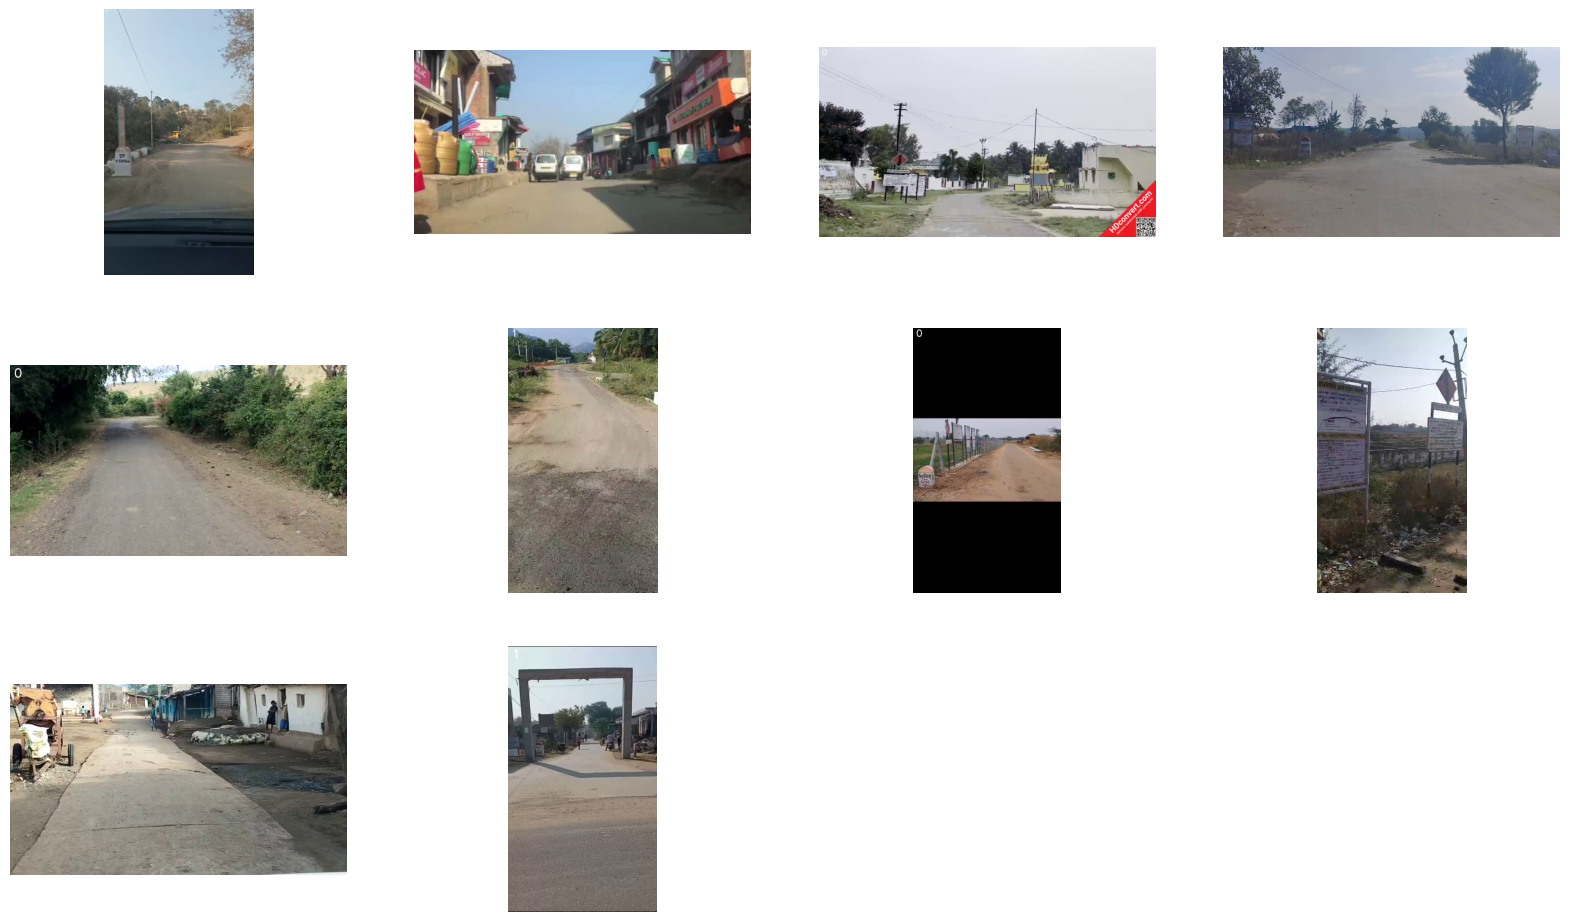

In [7]:
import os
import cv2
import json
import random
import matplotlib.pyplot as plt

# Define the function to convert time to frame index
def time_to_frame_index(time, fps):
    """Converts time in various formats to frame index."""
    try:
        # Split the time string into hours, minutes, and seconds
        if ':' in time:
            time_parts = time.split(':')
            if len(time_parts) == 3:
                hours, minutes, seconds = map(int, time_parts)
            else:
                minutes, seconds = map(int, time_parts)
                hours = 0
        else:
            # If ':' is not present, attempt to split by other delimiters
            for delimiter in [';', '.', ',']:
                if delimiter in time:
                    time_parts = time.split(delimiter)
                    if len(time_parts) == 3:
                        hours, minutes, seconds = map(int, time_parts)
                    else:
                        minutes, seconds = map(int, time_parts)
                        hours = 0
                    break
            else:
                # If no valid delimiter is found, assume the time format is 'SS' (seconds)
                hours, minutes, seconds = 0, 0, int(time)

        # Calculate the total seconds
        total_seconds = hours * 3600 + minutes * 60 + seconds

        # Calculate the frame index
        frame_index = int(total_seconds * fps)

        return frame_index
    except ValueError:
        print("Error: Invalid time format:", time)
        return 0  # Return 0 as a default value if time format is invalid


# Load annotations from the JSON file
with open('/home/shubhamp/Downloads/video_dataset/temporalDataset.json', 'r') as f:
    annotations = json.load(f)

# Path to your dataset directory
dataset_dir = '/home/shubhamp/Downloads/video_dataset/video_emarg'

# Create a dictionary to store annotations by video file name
video_annotations = {}

# Iterate over each item in the JSON list
for item in annotations:
    # Extract video path and segments
    video_path = item['path']
    segments = item['segments']

    # Extract video file name from the path
    video_file = os.path.basename(video_path)

    # Initialize a list to store frame indices and labels
    frame_annotations = []

    # Read video to get frame rate (fps)
    video_reader = cv2.VideoCapture(video_path)
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Iterate over each segment
    for segment in segments:
        # Convert start and end times to frame indices
        start_time = segment['start_time']
        end_time = segment['end_time']
        start_frame = time_to_frame_index(start_time, fps)
        end_frame = time_to_frame_index(end_time, fps)

        # Extract label
        label = segment['label']

        # Append frame index and label to the list
        for frame_index in range(start_frame, end_frame + 1):
            frame_annotations.append((frame_index, label))

    # Add video annotations to the dictionary
    video_annotations[video_file] = frame_annotations

# Select a random sample of 20 videos from your dataset
selected_videos = random.sample(list(video_annotations.keys()), 10)
# print("Total number of videos available:", len(video_annotations))
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize=(20, 20))

# Iterate through the selected videos
for i, video_file in enumerate(selected_videos, 1):
    # Read the video
    video_path = os.path.join(dataset_dir, video_file)
    video_reader = cv2.VideoCapture(video_path)

    # Read the first frame of the video
    _, frame = video_reader.read()

    # Convert the frame from BGR to RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get the corresponding annotation for the video
    annotation = video_annotations.get(video_file, [])

    # Select a random frame index with its annotation
    if annotation:
        frame_index, label = random.choice(annotation)
    else:
        frame_index = 0
        label = "No annotation"

    # Write the label on the video frame
    cv2.putText(rgb_frame, str(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    plt.subplot(5, 4, i)
    plt.imshow(rgb_frame)
    plt.axis('off')

    # Release the VideoCapture object
    video_reader.release()

plt.show()


6. Create a Function for Dataset Creation

In [8]:
import numpy as np
import cv2
import os
import json

def create_dataset_for_video(video_tensor, annotations_file, video_file, batch_size=8, downsample_factor=1):
    # Load annotations from the JSON file
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)

    # Extract video path
    video_path = video_file

    # Initialize lists to store features, labels, and video file paths
    features = []
    labels = []
    video_file_paths = []

    # Get the base filename from the specified video file
    specified_video_filename = os.path.basename(video_file)

    # Iterate through each item in the JSON list
    for item in annotations:
        # Extract video path and segments
        current_video_file = item['path']
        # Print filenames for debugging
        print("Current Video File:", os.path.abspath(current_video_file))
        print("Specified Video File:", os.path.abspath(video_file))


        # Check if the current video matches the specified video file
        if current_video_file == video_file:
            # Read the video to get frame rate (fps)
            print("Segments for specified video:")
            print(item['segments'])
            video_reader = cv2.VideoCapture(video_path)
            fps = video_reader.get(cv2.CAP_PROP_FPS)

            # Iterate over each segment
            for segment in item['segments']:
                # Convert start and end times to frame indices
                start_time = segment['start_time']
                end_time = segment['end_time']
                start_frame = time_to_frame_index(start_time, fps)
                end_frame = time_to_frame_index(end_time, fps)

                # Extract label
                label = segment['label']

                # Extract frames from video_tensor
                segment_frames = video_tensor[start_frame:end_frame+1]

                # Downsample frames if necessary
                if downsample_factor > 1:
                    segment_frames = segment_frames[:, ::downsample_factor, ::downsample_factor]

                # Add frames and labels to the lists
                features.append(segment_frames)
                labels.append(label)  # Append instead of extend to keep labels for each segment
                video_file_paths.append(video_file)  # Append instead of extend
            
            # Break the loop once the current and specified videos match
            break

    # Convert lists to numpy arrays
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    video_file_paths = np.asarray(video_file_paths)


    # Calculate the number of batches
    num_batches = len(features) // batch_size
    if len(features) % batch_size != 0:
        num_batches += 1  # Include an additional batch for remaining samples

    # Split features and labels into batches
    features_batches = np.array_split(features, num_batches)
    labels_batches = np.array_split(labels, num_batches)
    video_file_paths_batches = np.array_split(video_file_paths, num_batches)

    return features_batches, labels_batches, video_file_paths_batches

# Name of the video file you want to use
video_file = "/home/shubhamp/Downloads/video_dataset/video_emarg/Jamulni - Adumber.mp4"
annotations_file = "/home/shubhamp/Downloads/video_dataset/temporalDataset.json"

# Create the dataset for the specified video
video_tensor = frames_extraction(video_file)
features, labels, video_files_paths = create_dataset_for_video(video_tensor, annotations_file, video_file, downsample_factor=1)

print("Number of segments found:", len(features))
print("Shape of the first segment:", features[0].shape)


Current Video File: /home/shubhamp/Downloads/video_dataset/video_emarg/Jamulni - Adumber.mp4
Specified Video File: /home/shubhamp/Downloads/video_dataset/video_emarg/Jamulni - Adumber.mp4
Segments for specified video:
[{'start_time': '00:00', 'end_time': '00:05', 'label': 0}, {'start_time': '00:05', 'end_time': '00:10', 'label': 1}, {'start_time': '00:10', 'end_time': '00:30', 'label': 0}, {'start_time': '00:30', 'end_time': '01:24', 'label': 1}, {'start_time': '01:24', 'end_time': '01:44', 'label': 0}, {'start_time': '01:44', 'end_time': '02:05', 'label': 1}, {'start_time': '02:05', 'end_time': '02:08', 'label': 0}, {'start_time': '02:08', 'end_time': '02:18', 'label': 1}, {'start_time': '02:18', 'end_time': '02:27', 'label': 0}, {'start_time': '02:27', 'end_time': '03:16', 'label': 1}, {'start_time': '03:16', 'end_time': '03:20', 'label': 0}, {'start_time': '03:20', 'end_time': '03:50', 'label': 1}, {'start_time': '03:50', 'end_time': '04:00', 'label': 0}, {'start_time': '04:00', 'en

In [9]:
labels

[array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1])]

In [10]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Convert features list to numpy array and remove the extra dimension
features_array = np.array(features)
features_tensor = torch.tensor(features_array.squeeze())  # Remove the extra dimension from features
labels_tensor = torch.tensor(labels)  # Convert labels to tensor
labels_tensor = labels_tensor.squeeze()  # Remove the extra dimension from labels
print("Features size:", features_tensor.size())
print("Labels size:", labels_tensor.size())

# Ensure that the number of samples in features and labels match
num_samples = min(features_tensor.size(0), labels_tensor.size(0))
features_tensor = features_tensor[:num_samples]
labels_tensor = labels_tensor[:num_samples]

# Create TensorDataset
dataset = TensorDataset(features_tensor, labels_tensor)
print("Length of the dataset:", len(dataset))

# Define the train-test split ratio
train_ratio = 0.75

# Calculate the sizes of train and test sets
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Print the sizes of train and test datasets
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Check if the train dataset is empty
if len(train_dataset) > 0:
    # Create DataLoader for train and test sets
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
else:
    print("Train dataset is empty. Please check your data or adjust the train-test split ratio.")


Features size: torch.Size([20, 3, 224, 224])
Labels size: torch.Size([24])
Length of the dataset: 20
Train dataset size: 15
Test dataset size: 5


7. Implement the ConvLSTM Approach

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet152 model
resnet152 = models.resnet152(pretrained=True)

# Modify the ResNet152 model according to your needs, e.g., change the output features
# For example, if you want to change the output features to 512:
num_features = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_features, 256)

# Freeze the ResNet layers to prevent them from being trained
for param in resnet152.parameters():
    param.requires_grad = False

# Define the LSTM layers
input_size = 256  # Output features from ResNet152
hidden_size = 128  # Number of hidden units in LSTM
num_layers = 1  # Number of LSTM layers
batch_first = True  # Input and output tensors are provided as (batch, seq, feature)

lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)

class ResNetLSTMModel(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(ResNetLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.resnet = resnet152  # Using the modified ResNet152 model
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Remove the processing for sequence length
        x = x.view(-1, 3, 224, 224)  # Flatten the batch dimension
        features = self.resnet(x)
        # Adjust the processing to handle single images
        features = features.view(-1, 1, self.hidden_size)
        _, (h_n, _) = self.lstm(features)
        out = self.fc(h_n.squeeze(0))
        return out


# Define the number of classes
num_classes = len(CLASSES_LIST)  # Example number of classes

# Instantiate the combined model
model = ResNetLSTMModel(hidden_size, num_classes)

# Print the model architecture
print(model)


ResNetLSTMModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [12]:
! pip install wandb

8. Compile & Train the Model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import wandb

# Initialize wandb with error handling
try:
    wandb.init(project="Conv+LSTM_EMARG", name="metric_plots")
except wandb.errors.Error as e:
    print(f"Wandb initialization error: {e}")
    wandb.init(project="Conv+LSTM_eMARG", name="metric_plots", resume=True)

# Define your ConvLSTMModel
input_channels = 3  # Assuming RGB input
num_classes = len(CLASSES_LIST)  # Number of output classes
model = ResNetLSTMModel(hidden_size, num_classes)

# Define your loss function, optimizer, and early stopping criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
patience = 10
best_loss = float('inf')
counter = 0
best_model_path = 'best_model.pth'

# Assuming you have your actual training and validation data tensors
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=4)

for epoch in range(50):  # Number of epochs
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
    train_loss /= len(train_loader.dataset)
    train_accuracy = accuracy_score(train_targets, train_preds)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(val_targets, val_preds)
    
    # Log parameters to wandb with error handling
    try:
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy,
                   "Val Loss": val_loss, "Val Accuracy": val_accuracy})
    except wandb.errors.Error as e:
        print(f"Wandb logging error: {e}")
    
    print(f'Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shubhampundhir. Use `wandb login --relogin` to force relogin


Epoch [1/50], Train Loss: 0.7069, Train Accuracy: 0.4000, Val Loss: 0.7218, Val Accuracy: 0.4000
Epoch [2/50], Train Loss: 0.6846, Train Accuracy: 0.5333, Val Loss: 0.7364, Val Accuracy: 0.4000
Epoch [3/50], Train Loss: 0.6701, Train Accuracy: 0.6667, Val Loss: 0.7395, Val Accuracy: 0.4000
Epoch [4/50], Train Loss: 0.6634, Train Accuracy: 0.6667, Val Loss: 0.7415, Val Accuracy: 0.2000
Epoch [5/50], Train Loss: 0.6607, Train Accuracy: 0.7333, Val Loss: 0.7484, Val Accuracy: 0.2000
Epoch [6/50], Train Loss: 0.6271, Train Accuracy: 0.8667, Val Loss: 0.7695, Val Accuracy: 0.4000
Epoch [7/50], Train Loss: 0.6212, Train Accuracy: 0.6667, Val Loss: 0.7767, Val Accuracy: 0.4000
Epoch [8/50], Train Loss: 0.5875, Train Accuracy: 0.7333, Val Loss: 0.7462, Val Accuracy: 0.6000
Epoch [9/50], Train Loss: 0.5672, Train Accuracy: 0.8667, Val Loss: 0.6807, Val Accuracy: 0.4000
Epoch [10/50], Train Loss: 0.5219, Train Accuracy: 0.9333, Val Loss: 0.6228, Val Accuracy: 0.6000
Epoch [11/50], Train Loss: 0.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import wandb

# Initialize wandb with error handling
try:
    wandb.init(project="Conv+LSTM_EMARG", name="metric_plots")
except wandb.errors.Error as e:
    print(f"Wandb initialization error: {e}")
    wandb.init(project="Conv+LSTM_eMARG", name="metric_plots", resume=True)

# Define your ConvLSTMModel
input_channels = 3  # Assuming RGB input
num_classes = len(CLASSES_LIST)  # Number of output classes
model = ResNetLSTMModel(hidden_size, num_classes)

# Define your loss function, optimizer, and early stopping criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
patience = 10
best_loss = float('inf')
counter = 0
best_model_path = 'best_resnet152-model.pth'

# Assuming you have your actual training and validation data tensors
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=4)

for epoch in range(50):  # Number of epochs
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
    train_loss /= len(train_loader.dataset)
    train_accuracy = accuracy_score(train_targets, train_preds)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(val_targets, val_preds)
    
    # Log parameters to wandb with error handling
    try:
        wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy,
                   "Val Loss": val_loss, "Val Accuracy": val_accuracy})
    except wandb.errors.Error as e:
        print(f"Wandb logging error: {e}")
    
    print(f'Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


Train Accuracy,▁▃▄▄▅▆▄▅▆▇█▆██▆▆▇▇▇███▄▆▆▆█
Train Loss,███▇▇▇▇▇▆▆▅▅▄▄▅▄▄▃▂▂▂▂▆▄▄▂▁
Val Accuracy,▃▃▃▁▁▃▃▆▃▆▆▃▆█▆█▆▆███▃▃▃███
Val Loss,▆▇▇▇▇██▇▅▃▂▂▃▂▄▂▁▁▄▄▃▄▇▄▄▂▂
Train Accuracy,1.0
Train Loss,0.10065
Val Accuracy,0.8
Val Loss,0.58598


RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 128

9. Evaluate the trained model:

In [34]:
# Initialize variables to store evaluation results
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# Iterate over the test loader
for inputs, labels in test_loader:
    # Forward pass
    outputs = model(inputs)
    
    # Calculate loss
    loss = criterion(outputs, labels)
    test_loss += loss.item() * inputs.size(0)
    
    # Convert probabilities to class predictions
    _, predicted = torch.max(outputs, 1)
    
    # Calculate number of correct predictions
    correct_predictions += torch.sum(predicted == labels).item()
    
    # Update total predictions
    total_predictions += labels.size(0)

# Calculate average loss
test_loss /= len(test_loader.dataset)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print evaluation results
print(f'Val Loss: {test_loss:.4f}, val_accuracy: {accuracy:.4f}')


Val Loss: 1.4187, val_accuracy: 0.2000


2. Save the model:

In [36]:
import datetime as dt

# Define the string date format.
date_time_format = '%Y_%m_%d__%H_%M_%S'

# Get the current Date and Time in a DateTime Object.
current_date_time_dt = dt.datetime.now()

# Convert the DateTime object to string according to the style mentioned in date_time_format string.
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define file name for the saved model
model_file_name = 'convlstm_model_{}_Accuracy_{:.2f}.pt'.format(current_date_time_string, accuracy * 100)


In [37]:
# Define file name for the saved model
model_file_name = 'convlstm_model_{}_Accuracy_{:.2f}.pt'.format(current_date_time_string, accuracy * 100)

# Save the model state dictionary and other relevant information
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'accuracy': accuracy,
    'epoch': epoch
}, model_file_name)

print("Model saved successfully.")


Model saved successfully.
